# **UMAP (Uniform Manifold Approximation and Projection)**

## **Introduction**

**UMAP (Uniform Manifold Approximation and Projection)** is a novel
manifold learning technique for dimension reduction. It is constructed
from a theoretical framework based in **Riemannian geometry** and **algebraic
topology**.

The UMAP algorithm is **competitive** with t-SNE for visualization
quality, and arguably **preserves** more of the **global structure** with
superior **run time performance**. Furthermore the algorithm
is able to scale to significantly larger data set sizes than are feasible
for t-SNE. Finally, UMAP **has no computational restrictions** on embedding
dimension, making it viable as a general purpose dimension reduction technique
for machine learning

The **theoretical description** of the algorithm works in terms of **fuzzy
simplicial sets**. **Computationally** this is only tractable for the **one skeleton** which can ultimately be described as a **weighted graph**. This means that, from a practical computational perspective, UMAP can ultimately be described in terms of, construction of, and operations on, weighted graphs.
In particular this situates UMAP in the **class of $k$-neighbour based graph
learning algorithms** such as Laplacian Eigenmaps, Isomap and t-SNE.

As with other **$k$-neighbour graph based algorithms**, UMAP can be described
in two phases.

> In the first phase a particular **weighted k-neighbour
graph** is constructed.

> In the second phase a **low dimensional layout** of this
graph is computed.

The differences between all algorithms in this class amount to specific details in how the graph is constructed and how the layout is computed.

## **Theoretical Foundations for UMAP**

At a high level, UMAP uses **local manifold approximations** and patches
together their **local fuzzy simplicial set** representations to construct a **topological representation** of the high dimensional data. Given some low dimensional representation of the data, a similar process can be used to construct an **equivalent topological representation**. UMAP then optimizes the layout of the data representation in the low dimensional space, to **minimize the cross-entropy** between the **two topological representations**.

The construction of **fuzzy topological representations** can be broken
down into two problems: **approximating a manifold** on which the data is
assumed to lie; and **constructing a fuzzy simplicial set representation** of
the approximated manifold.

The method assume the data to be **uniformly distributed** on a **Riemannian manifold** $\mathscr{M}$ with respect to its **geodesic distance** $g$, then, (away from any boundaries) any ball of fixed volume should contain approximately the same number of points of $X$ regardless of where on the manifold it is centered. Given finite data and small enough local neighborhoods this crude approximation should be accurate enough even for data samples near manifold boundaries. Now, conversely, a ball centered at $X_i$ that contains exactly the $k$-nearest-neighbors of $X_i$ should have approximately
fixed volume regardless of the choice of $X_i\in X$. It can be show that we can **approximate geodesic distance** from $X_i$ to its neighbors by **normalising distances** with respect to the distance to the $k$th nearest neighbor of $X_i$.

In essence, by **creating a custom distance** for each $X_i$, we can **ensure**
the validity of the assumption of **uniform distribution on** the manifold. The
cost is that we now have an independent **notion of distance for each** and
every $X_i$, and these notions of distance **may not be compatible**. We have
a **family of discrete metric spaces** (one for each $X_i$) that **we wish to merge** into a **consistent global structure**. This can be done in a natural way by converting the **metric spaces** into **fuzzy simplicial sets**.

## **A computational view of UMAP**

The UMAP algorithm assumes the following assumptions about the data:
1. There **exists** a manifold on which the data would be **uniformly distributed**.
2. The underlying manifold of interest is **locally connected**.
3. **Preserving** the **topological structure** of this manifold is the primary
goal.

Any algorithm that attempts to use a $k$-neighbor graph-like mathematical structure to approximate a manifold must follow a similar **basic structure**:

* Graph construction:
  1. Construct a weighted $k$-neighbour graph.
  2. Apply some transform on the edges to ambient local distance.
  3. Deal with the inherent asymmetry of the k-neighbour graph.
* Graph Layout
  1. Define an objective function that preserves desired characteristics of this $k$-neighbour graph.
  2. Find a low dimensional representation which optimizes this objective function.

### **Graph Construction**

The first phase of UMAP can be thought of as the **construction** of a **weighted
$k$-neighbour graph**.

Let $X=\{x_1,\ldots,x_N\}$ be the input dataset, with a
**metric** (or **dissimilarity measure**)
$$d : X\times X \rightarrow \mathbb{R}^{+}\cup\{0\}$$

Given an input hyperparameter $k$, for each $x_i$ we compute the set $\{x_{i_1}, \ldots, x_{i_k}\}$ of the $k$ **nearest neighbors** of $x_i$ under the metric $d$. This computation can be performed via any nearest neighbour or approximate nearest neighbour search algorithm.

For each $x_i$ we will define $\rho_i$ and $\sigma_i$.

Let (The distance to the nearest neighbor)

$$\rho_i = \min \left\{d(x_i,x_{i_j}) \ | \ j=1,\ldots,k, \ d(x_i, x_{i_j})> 0 \right\}$$

[**Note:** The selection of $\rho_i$ derives from the **local-connectivity constraint**. In particular it ensures that $-i$ connects to at least one other data point with an edge of weight 1; this is equivalent to the resulting fuzzy simplicial set being locally connected at $x_i$. In practical terms this significantly
improves the representation on very high dimensional data where other lgorithms such as t-SNE begin to suffer from the curse of dimensionality.]

and set $\sigma_i$ to be the value such that

$$\sum_{j=1}^k \exp \left( \frac{-\max\left(0, d(x_i, x_{i_j})-\rho_i\right)}{\sigma_i} \right)=\log_2(k)$$

The selection of $\sigma_i$ corresponds to (a smoothed) **normalisation factor**, defining the **Riemannian metric local** to the point $x_i$

We can now define a weighted directed graph $\bar{G}=(V, E, w)$. The vertices $V$ of $\bar{G}$ are simply the set $X$. We can then form the set of directed edges
$$E=\{(x_i, x_{i_j}) \ | \ | j=1,\ldots,k, i=1,\ldots,N\}$$

and define the weight function $w$ by setting
$$w((w_i, x_{i_j})) = \exp \left( \frac{-\max\left(0, d(x_i, x_{i_j})-\rho_i\right)}{\sigma_i} \right)$$

For a given point $x_i$ there exists an **induced graph** of $x_i$ and outgoing edges incident on $x_i$. This graph is the **1-skeleton** of the **fuzzy simplicial set** associated to the **metric space local** to $x_i$ where the local metric is defined in terms of $\rho_i$ and $\sigma_i$. The weight associated to the edge is the **membership strength** of the corresponding 1-simplex within the fuzzy simplicial set.

Intuitively one can think of the **weight of an edge as being similar to the probability** that the given edge exists. It can be shown in theoretical terms that this construction faithfully captures the topology of the data.


Let $A$ be the weighted adjacency matrix of $\bar{G}$, and consider the symmetric matrix
$$B = A + A^T - A\circ A^T$$

where $\circ$ is the **Hadamard (or pointwise) product**

[This formula derives from the use of the **probabilistic $t$-conorm** used in unioning the fuzzy simplicial sets.] If one interprets the value of $A_{ij}$ as the probability that the directed edge from $x_i$ to $x_j$ exists, then $B_{ij}$ is the probability that at least one of the two directed edges (from $x_i$ to $x_j$ and from $x_j$ to $x_i$) exists.

The **UMAP graph** $G$ is then an **undirected weighted** graph whose adjacency matrix is given by $B$.

### **Graph layout**

In practice UMAP uses a **force directed graph layout algorithm** in **low dimensional space**. A  **force directed graph layout ** utilizes of a set of  **attractive forces** applied along  **edges** and a set of  **repulsive forces** applied among  **vertices**.

> Any  **force directed layout algorithm** requires a description of both the
attractive and repulsive forces. The algorithm proceeds by  **iteratively applying** attractive and repulsive forces at each edge or vertex. This is equivalent to a **non-convex optimization problem**. **Convergence** to a **local minima** is guaranteed by slowly decreasing the attractive and repulsive forces in a similar fashion to that used in simulated annealing.

In UMAP the **attractive force** between two vertices $i$ and $j$ at coordinates $\textbf{y}_i$ and $\textbf{y}_j$ respectively, is determined by
$$\frac{-2ab \|\textbf{y}_i-\textbf{y}_j\|_2^{2(b-1)}}{1+\|\textbf{y}_i-\textbf{y}_j\|_2^2}w\left((x_i, x_{i_j} \right)(\textbf{y}_i-\textbf{y}_j)$$

where $a$ and $b$ are hyper-parameters.

**Repulsive forces** are computed via sampling due to computational constraints.
Thus, whenever an attractive force is applied to an edge, one of that edge's vertices is repulsed by a sampling of other vertices. The repulsive
force is given by

$$\frac{2b}{(\epsilon + \|\textbf{y}_i-\textbf{y}_j\|_2^2)(1+a\|\textbf{y}_i -\textbf{y}_j\|_2^{2b})}(1-w((x_i, x_{i_k})))(\textbf{y}_i-\textbf{y}_j)$$

$\epsilon$ is a small number to prevent division by zero (0.001 in the current
implementation).

The ealgorithm can be **initialized randomly** but in practice, since the symmetric Laplacian of the graph $G$ is a discrete approximation of the **Laplace-Beltrami operator** of the manifold, we can use a **spectral layout** to initialize the embedding. This provides both **faster convergence** and **greater stability** within the algorithm.

The forces described above are derived from **gradients** optimising the
**edge-wise cross-entropy** between the weighted graph $G$, and an equivalent
weighted graph $H$ constructed from the points $\{\textbf{y}_i\}_{i=1,\ldots,N}$ is, we are seeking to position points $\textbf{y}_i$ such that the weighted graph induced by those points most closely **approximates the graph** $G$, where we measure the **difference between weighted graphs** by the **total cross entropy** over all the **edge existence probabilities**. Since the weighted graph $G$ **captures the topology** of the source data, the equivalent weighted graph $H$ constructed from the points $\{\textbf{y}_i\}_{i=1,\ldots,N}$ matches the topology as closely as the optimization allows, and thus provides a **good low dimensional representation** of the **overall topology** of the data.

### **Algorithm description**

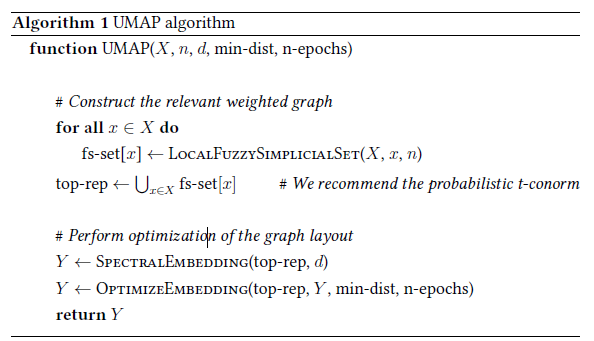

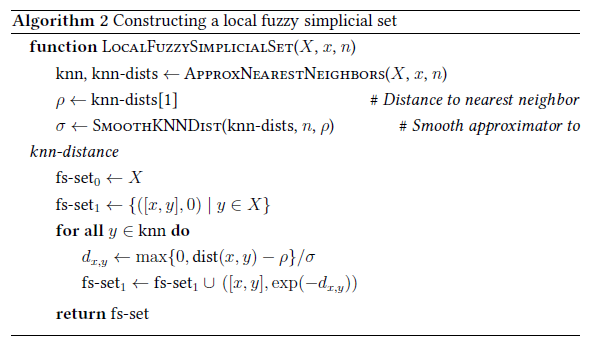

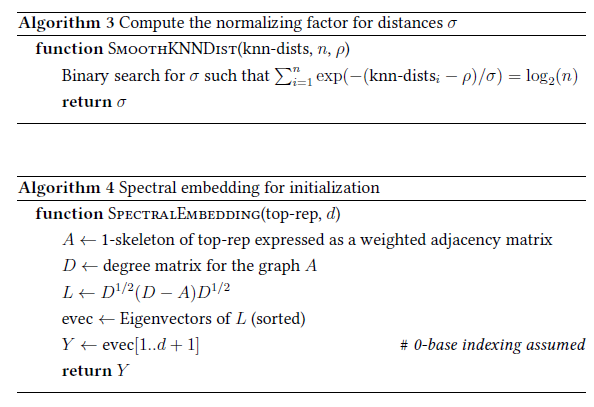

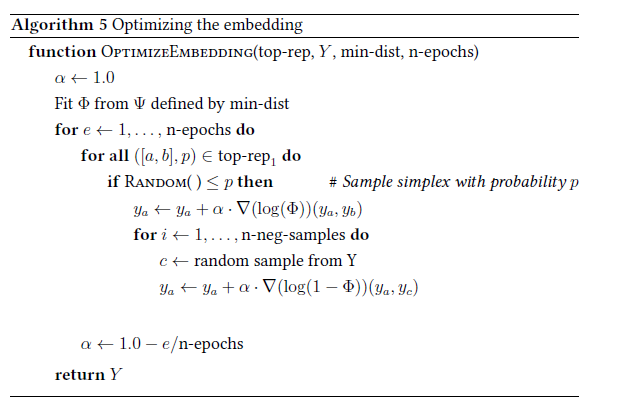

### **Hyper-parameters**

The **UMAP algorithm** takes four **hyper-parameters**:
1. $k$, the number of neighbors to consider when approximating the local
metric;
2. $d$, the target embedding dimension;
3. $min-dist$, the desired separation between close points in the embedding
space;
4. $n-epochs$, the number of training epochs to use when optimizing the
low dimensional representation

One can interpret the number of neighbors $k$ as the **local scale** at which
to **approximate** the **manifold as roughly flat**, with the manifold estimation averaging over the $k$ neighbors.

> Manifold features that occur at a smaller scale than within the $n$ nearest-neighbors of points will be lost, while large scale manifold features that cannot be seen by patching together locally flat charts at the scale of $k$ nearest-neighbors may not be well detected.}

Thus $n$ represents some **degree of trade-off** between  **fine grained** and **large scale manifold features** — smaller values will ensure detailed manifold structure is accurately captured (at a loss of the *big picture* view of the manifold),
while larger values will capture large scale manifold structures, but at a loss
of fine detail structure which will get averaged out in the local approximations.

In contrast $min-dist$ is a hyperparameter directly affecting the **output**,
as it **controls the fuzzy simplicial set construction** from the low dimensional representation. It acts in lieu of the distance to the nearest neighbor used to ensure local connectivity. In essence this determines **how closely pointscan be packed together** in the low dimensional representation.
> **Low values** on $min-dist$ will result in potentially **densely packed regions**, but will likely more faithfully represent the manifold structure.
> **Increasing** the value of $min-dist$ will force the embedding to **spread points** out more, assisting visualization (and avoiding potential overplotting issues).

We view $min-dist$ as an essentially **aesthetic parameter**, governing the
appearance of the embedding, and thus is more important when using UMAP for visualization

#### Visualization example of UMAP for variation of hyperparameters $k$ and $min-dist$ usint the **digit dataset**

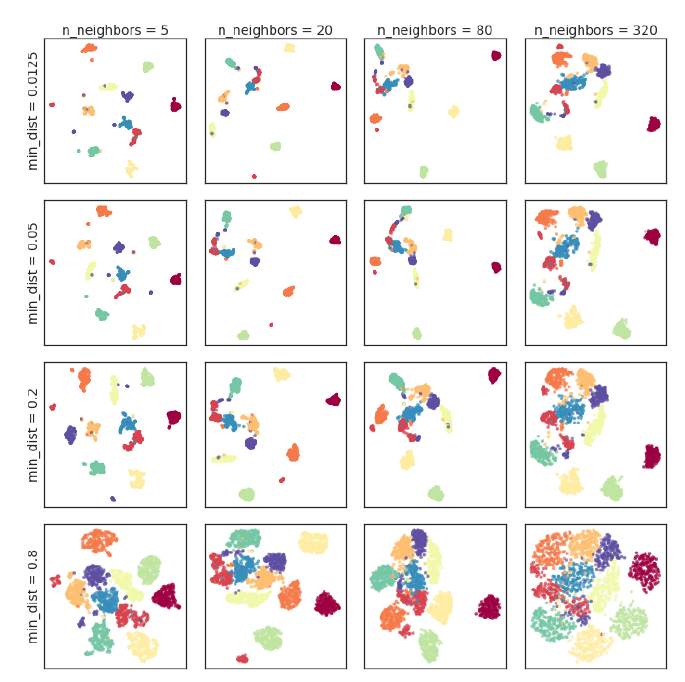

## **References**

* McInnes, L., Healy, J., & Melville, J. (2020) *UMAP: Uniform Manifold
Approximation and Projection for Dimension Reduction*, in **ArXiv**, 1802.03426v3.